In [ ]:
!pip install svgling
!pip install yake
# !pip install pytextrank
!python3 -m spacy download en_core_web_sm
!pip install sentence-transformers

In [ ]:
import pandas as pd
import numpy as np
import math
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from collections import Counter
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import yake
import spacy
# import pytextrank
from nltk.corpus import stopwords
import svgling
from gensim.summarization import keywords
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import itertools
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
reviews = pd.read_csv('reviews.csv', parse_dates=['date'])

reviews.head()

,name,title,review,rating,rating_out_of,date
0,Md Alam,West not working,Bekar,1.0,5.0,2021-11-17
1,Hema,Was not good don't buy this,It was not good.. For earphones connection it...,1.0,5.0,2021-11-09
2,Mahesh kumar,Just ok,Jaldi kharab ho gaya,3.0,5.0,2021-11-07
3,amey ghatge,Product not working,Within one month this product has stopped work...,1.0,5.0,2021-10-09
4,Lobzang Dorjay,Superb product,Sound quality is just great if we use earphone...,3.0,5.0,2021-09-04


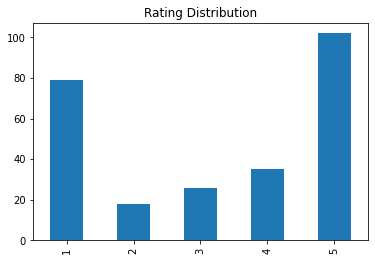

In [ ]:
(reviews['rating']
  .map(round)
  .value_counts()
  .sort_index()
  .plot(kind='bar', title='Rating Distribution')
);

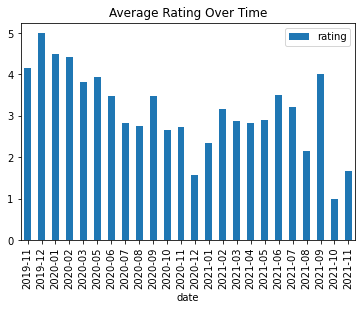

In [ ]:
(reviews
  .groupby(by=reviews['date'].dt.to_period('M'))
  .agg({'rating': 'mean'})
  .plot(kind='bar', title='Average Rating Over Time')
);

# preprocessing

In [ ]:
en_stopwords = set(stopwords.words('english'))

def undo_contractions(phrase):
    # specific
    phrase = re.sub(r"won[\'’]t", "will not", phrase)
    phrase = re.sub(r"can[\'’]t", "can not", phrase)

    # general
    phrase = re.sub(r"n[\'’]t", " not", phrase)
    phrase = re.sub(r"[\'’]re", " are", phrase)
    phrase = re.sub(r"[\'’]s", " is", phrase)
    phrase = re.sub(r"[\'’]d", " would", phrase)
    phrase = re.sub(r"[\'’]ll", " will", phrase)
    phrase = re.sub(r"[\'’]t", " not", phrase)
    phrase = re.sub(r"[\'’]ve", " have", phrase)
    phrase = re.sub(r"[\'’]m", " am", phrase)
    return phrase

emoji_regex = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # dingbats
    u"\u3030"
                  "]+", re.UNICODE)

def lemmatize(sentence):
  return WordNetLemmatizer().lemmatize(sentence)

def pos_filter(tokens):
  unwanted_pos = set([
                      'CC', 
                      'DT',
                      'EX', 
                      'IN', 
                      'MD', 
                      'PRP', 'PRP$', 
                      # 'RB', 
                      'RBR', 'RBS',
                      'RP', 
                      'TO', 
                      'UH', 
                      'WP', 'WP$',
                      'WRB'
  ])
  tokens = pos_tag(tokens)
  tokens = [
      token for token, pos in tokens 
      if (pos not in unwanted_pos)
  ]
  return tokens

def filter_min_length(words):
  return [word for word in words if len(word) > 2]


In [ ]:
reviews['text'] = reviews['title'] + ' . ' + reviews['review']

reviews['tokenized'] = (reviews['text']
  .fillna('')
  .str.replace(r'([a-z]+)([A-Z])', r'\1 \2') # badProduct bad Product
  .str.lower()
  .str.replace(emoji_regex, '')
  .str.replace('\n', '.')
  .str.replace(r'\s*\.+\s*', '. ')
  .apply(undo_contractions)
  # .apply(lemmatize)
  .apply(word_tokenize)
  # .apply(pos_filter)
  # .apply(lambda tokens : [token for token in tokens if token not in en_stopwords])
  # .apply(filter_min_length)
)

reviews['text_cleaned'] = reviews['tokenized'].str.join(" ")

reviews['text_cleaned'][:5].values

array(['west not working . bekar',
       'was not good do not buy this . it was not good . for earphones connection it was not working correctly',
       'just ok. jaldi kharab ho gaya',
       'product not working . within one month this product has stopped working . does anyone from company read this ? let me know how to replace or return this product ?',
       'superb product . sound quality is just great if we use earphones a d headphones .'],
      dtype=object)

# extract keywords

In [ ]:
def extract_keywords_yake(corpus):
  kws = []

  kw_extractor = yake.KeywordExtractor(
      top=5,
  )

  for i, doc in enumerate(corpus):
    num_words = len(doc.split(" "))
    if num_words > 25:
      kw = kw_extractor.extract_keywords(doc)
    else:
      kw = []
    kws.append(kw)
  return kws

In [ ]:
kws = extract_keywords_yake(reviews['text_cleaned'])

In [ ]:
kws_with_ratings = list(zip(kws, reviews['rating']))

In [ ]:
yake_threshold = 0.01
keywords_flat = []
ratings_map = {}

for doc_keywords, rating in kws_with_ratings:
  for keyword, score in doc_keywords:
    if score <= yake_threshold:
      keywords_flat.append((keyword, score))
      if keyword not in ratings_map:
        ratings_map[keyword] = []
      ratings_map[keyword].append(rating)

# average ratings
ratings_map = {k : np.mean(v) for k, v in ratings_map.items()}

In [ ]:
def remove_duplicates(keywords):
  keywords = sorted(keywords, key=lambda a : a[1])

  unique_keywords = []
  temp_extractor = yake.KeywordExtractor()

  distance_function = temp_extractor.dedu_function
  duplication_threshold = 0.9

  for keyword, score in keywords:

    should_add = True

    for kw, score in unique_keywords:
      distance = distance_function(keyword, kw)
      if distance > duplication_threshold:
          should_add = False
          break

    if should_add:
      unique_keywords.append((keyword, score))

  return unique_keywords

In [ ]:
keywords_unique = remove_duplicates(keywords_flat)

# cluster keywords

In [ ]:
transformer_model = 'distilbert-base-nli-mean-tokens'
cluster_distance_threshold = 1.45

# transformer_model = 'all-MiniLM-L6-v2'
# cluster_distance_threshold = 2

In [ ]:
def embed_corpus(corpus, transformer_model):
  # embed
  # distilbert-base-nli-mean-tokens
  # embedder = SentenceTransformer('all-MiniLM-L6-v2')
  embedder = SentenceTransformer(transformer_model)

  # embed keywords
  corpus_embeddings = embedder.encode(corpus)

  # Normalize to unit norm
  corpus_embeddings = corpus_embeddings / np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

  return corpus_embeddings

def cluster_corpus(embeddings, threshold):
  # clustering model
  model = AgglomerativeClustering(
    n_clusters=None, 
    distance_threshold=threshold)
  
  # cluster index for each document in corpus
  # shape: len(embeddings)
  cluster_assignment = model.fit_predict(embeddings)

  # clusters
  clusters = {}

  # points in cluster
  for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clusters:
      clusters[cluster_id] = {
          'points': [],
          'embeddings': [],
          'centroid': None,
          'distances': None,
      }
    clusters[cluster_id]['points'].append(sentence_id)
    clusters[cluster_id]['embeddings'].append(embeddings[sentence_id])

  # centroid and distance from centroid
  for cluster_id in clusters.keys():
    clusters[cluster_id]['embeddings'] = np.array(clusters[cluster_id]['embeddings'])
    clusters[cluster_id]['points'] = np.array(clusters[cluster_id]['points'])

    embedding = clusters[cluster_id]['embeddings']

    centroid = np.mean(embedding, axis=0)
    clusters[cluster_id]['centroid'] = centroid

    distances = cosine_similarity(embedding, np.expand_dims(centroid, 0))
    clusters[cluster_id]['distances'] = distances

  # center of clusters
  return clusters

In [ ]:
# discard scores keep keywords only
corpus = [keyword[0] for keyword in keywords_unique]

# compute embedding for corpus
embeddings = embed_corpus(corpus, transformer_model)

# cluster in distinct points
clusters = cluster_corpus(embeddings, cluster_distance_threshold)

num_clusters = len(clusters.keys())

print(f"{num_clusters} clusters formed")

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

15 clusters formed


In [ ]:
def visualize_cluster(cluster, corpus, ratings_map, ax=None):
  cluster_docs = corpus[cluster['points']]

  freq = [(doc, float(1/cluster['distances'][i])) for i, doc in enumerate(cluster_docs)]
  freq = dict(freq)
  
  def color_func(word, **kwargs):
    rating = ratings_map[word]
    if rating <= 2:
      return "red"
    if rating <= 4:
      return "blue"
    return "green"

  wc = WordCloud(color_func=color_func, width=800, height=400).generate_from_frequencies(freq)

  if ax is None:
    ax = plt.gca()

  ax.imshow(wc)
  return ax

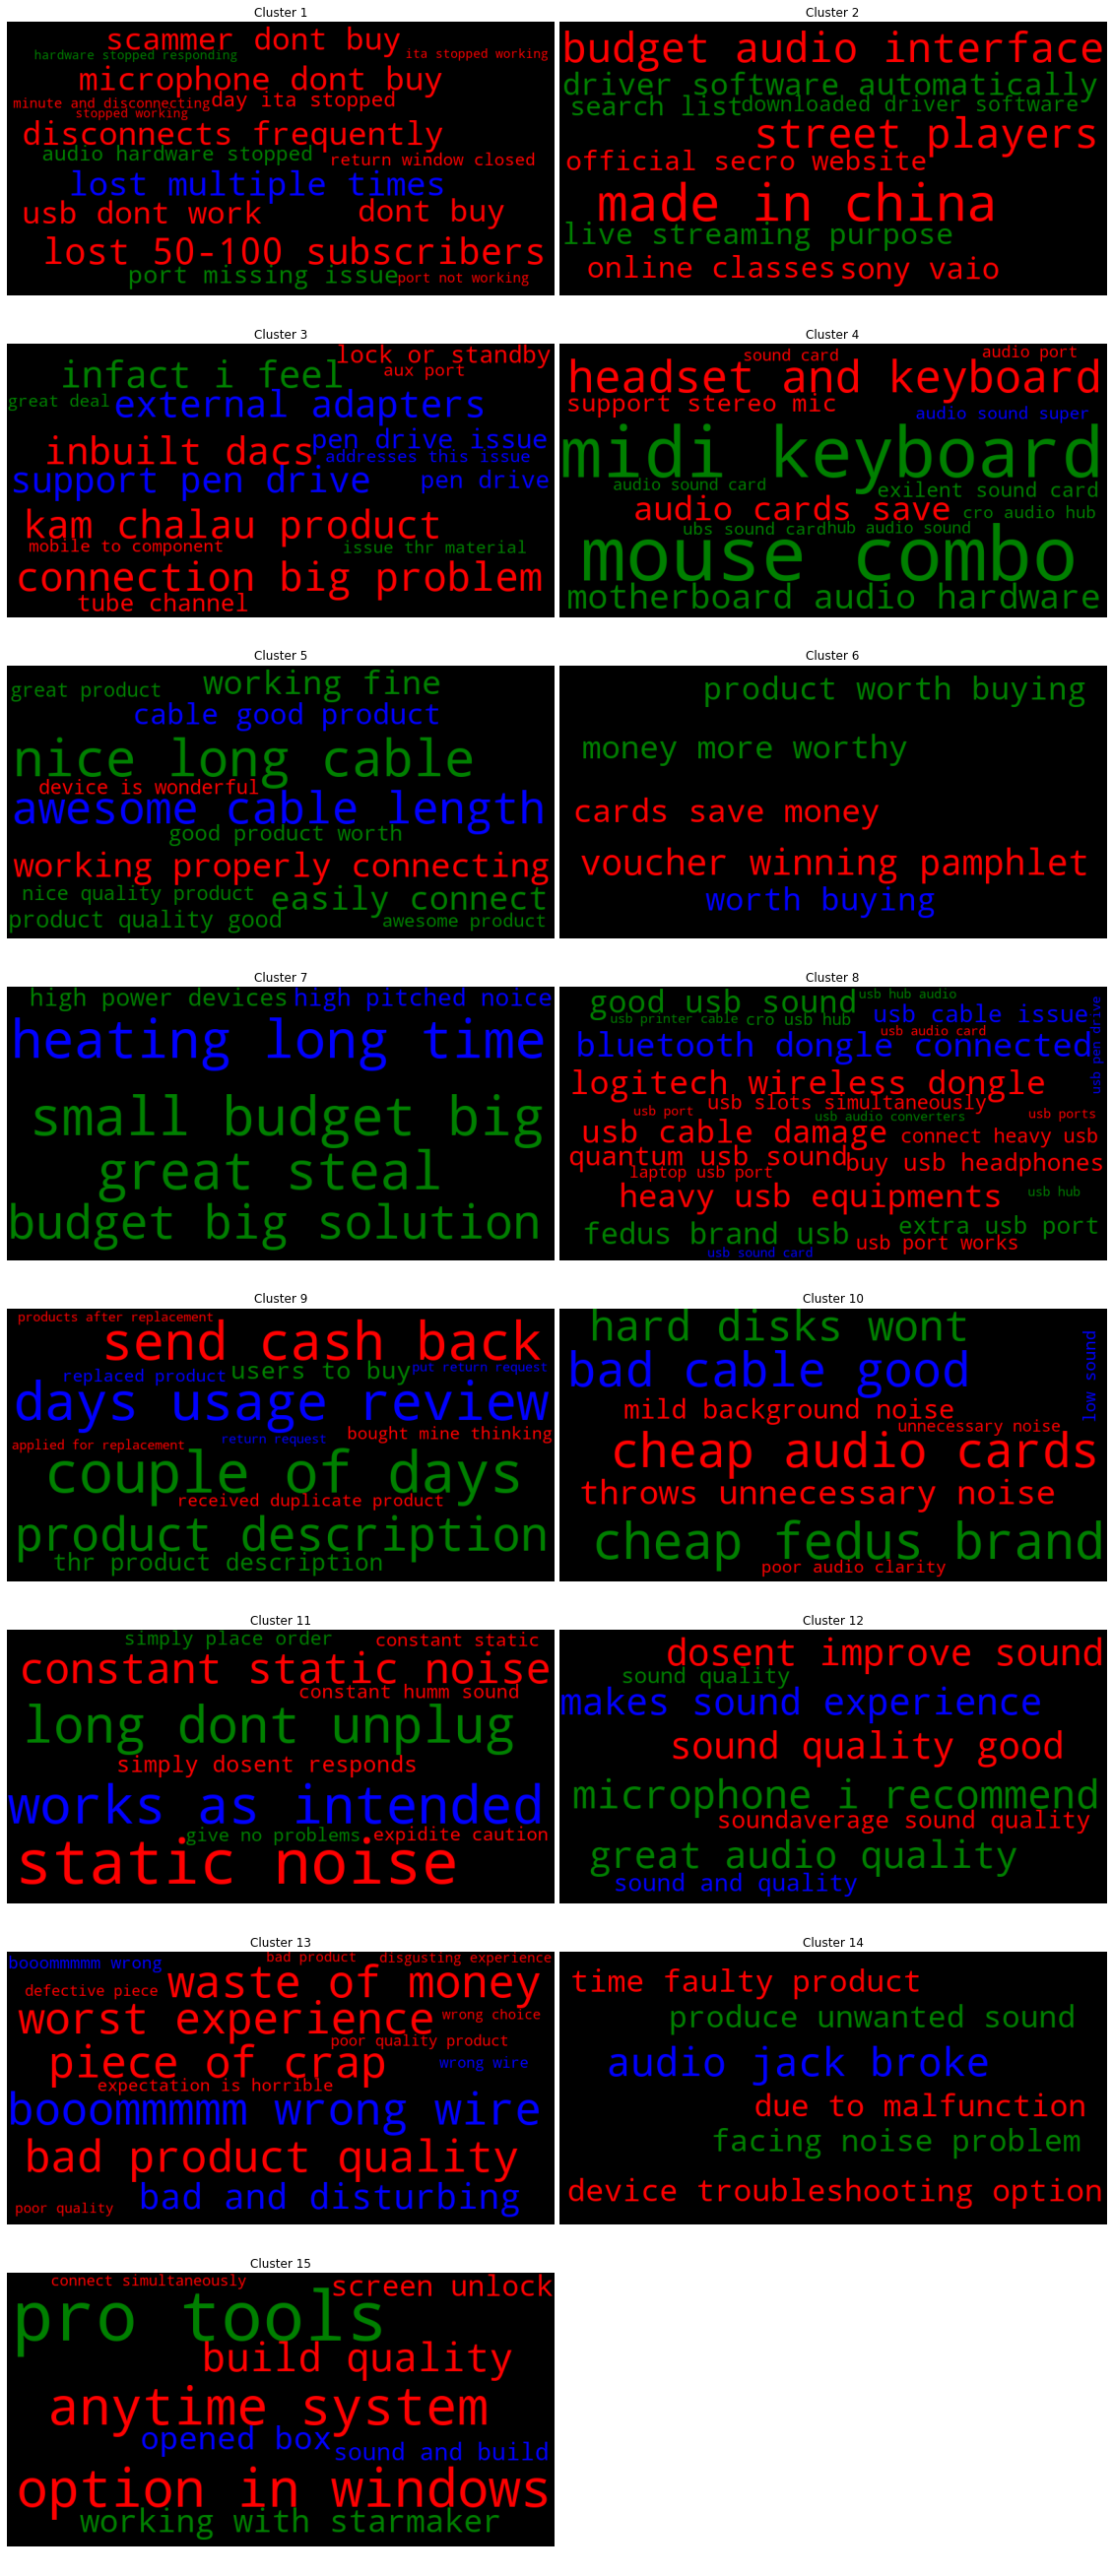

In [ ]:
num_clusters = len(clusters)

corpus_numpy = np.array(corpus)

nrows = math.ceil(num_clusters / 2)
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows*6))
fig.subplots_adjust(hspace=0.01, wspace=0.01)

fig.set_label("Word Cloud For Clusters")

axs = np.ravel(axs)

for i in clusters.keys():
  ax = axs[i]
  visualize_cluster(clusters[i], corpus_numpy, ratings_map, ax)
  ax.set_title(f"Cluster {i+1}")

for ax in axs:
  ax.set_axis_off()